In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast
import re
import seaborn as sns
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.metrics import  mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, SGDRegressor
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import train_test_split, cross_val_score
import warnings

warnings.filterwarnings("ignore")

In [2]:
lista_numeros = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 18, 20, 21, 23, 25, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 77, 79, 81, 83, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 107, 109, 113, 114, 127, 129, 131, 132, 133, 134, 137, 139, 145, 146, 153, 167, 179, 184, 185, 201, 204, 210, 211, 219, 223, 227, 232, 236, 248, 251, 280, 287, 308, 315, 322, 331, 347, 363, 364, 371, 392, 394, 415, 459, 476, 500, 510, 515, 521, 522, 527, 528, 611, 625, 626, 627, 632, 657, 661, 663, 665, 667, 669, 671, 672, 674, 684, 686, 687, 688, 689, 693]

In [3]:
listings = pd.read_csv('Data/2023-07-27_12h56m43s_df.csv', sep=';')
pd.set_option('display.max_columns', len(listings.columns))
print(f"The dataset contains {len(listings)} Airbnb listings")

The dataset contains 320 Airbnb listings


In [4]:
listings = listings.fillna(0)

In [5]:
listings.city.unique()

array(['Rio de Janeiro', 'Ipanema', 'Rio', 'Flamengo', 'Rio de Janeiro ',
       'Copacabana', 'Leblon', 'Botafogo', 'Barra da Tijuca', 'Glória',
       'Centro', 'Recreio dos Bandeirantes', 'Laranjeiras',
       'São Cristóvão', 'Jardim Guanabara', 'Urca', 'Taquara', 'Ingá', 0,
       'Gávea', 'Jacarepaguá', 'Leme', 'Estácio', 'Vila Valqueire',
       'Catete', 'Niterói', 'Pechincha', 'Vidigal',
       'Rio de Janeiro - Copacabana', 'Lagoa', 'Cachambi',
       'Duque de Caxias ', 'Santa Rosa', 'Santa Teresa', 'Campo Grande',
       'Santa Teresa, Rio de Janeiro', 'Rio De Janeiro', 'Bancários',
       'Humaitá', 'RIO DE JANEIRO'], dtype=object)

In [6]:
listings.city.replace({
    'Rio': 'Rio de Janeiro',
    'Rio de Janeiro ': 'Rio de Janeiro',
    'Rio de Janeiro - Copacabana': 'Copacabana',
    'Santa Teresa, Rio de Janeiro': 'Santa Teresa',
    'Rio De Janeiro': 'Rio de Janeiro',
    'RIO DE JANEIRO': 'Rio de Janeiro'}, inplace=True)

In [7]:
listings.city.unique()

array(['Rio de Janeiro', 'Ipanema', 'Flamengo', 'Copacabana', 'Leblon',
       'Botafogo', 'Barra da Tijuca', 'Glória', 'Centro',
       'Recreio dos Bandeirantes', 'Laranjeiras', 'São Cristóvão',
       'Jardim Guanabara', 'Urca', 'Taquara', 'Ingá', 0, 'Gávea',
       'Jacarepaguá', 'Leme', 'Estácio', 'Vila Valqueire', 'Catete',
       'Niterói', 'Pechincha', 'Vidigal', 'Lagoa', 'Cachambi',
       'Duque de Caxias ', 'Santa Rosa', 'Santa Teresa', 'Campo Grande',
       'Bancários', 'Humaitá'], dtype=object)

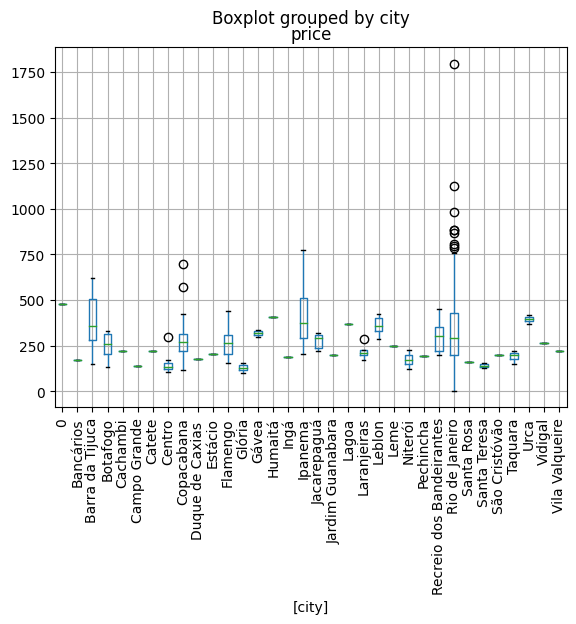

In [8]:
listings.boxplot('price', ['city'], rot=90);

In [9]:
listings = listings.drop(labels=[3, 4, 17, 41, 131, 148, 165, 212, 247, 273, 286, 126, 287, 297, 302], axis=0)

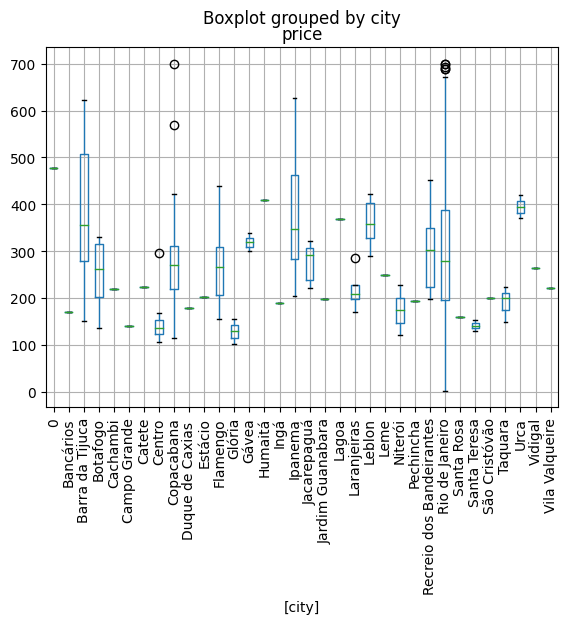

In [10]:
listings.boxplot('price', ['city'], rot=90);

In [11]:
listings['amenities'] = listings['amenities'].apply(lambda x: ast.literal_eval(x))
for num in lista_numeros:
    values = [any(num == item for item in row['amenities']) for _, row in listings.iterrows()]
    listings[str(num)] = values

In [12]:
# Produces a list of amenity features where one category (true or false) contains fewer than 10% of listings
# infrequent_amenities = []
# for col in listings.iloc[:,26:].columns:
#     if listings[col].sum() < len(listings)/4:
#         infrequent_amenities.append(col)
# print(infrequent_amenities)

# # Dropping infrequent amenity features
# listings.drop(infrequent_amenities, axis=1, inplace=True)

In [13]:
lista = []
for col, val in listings.iterrows():
    for amenity in val.amenities:
        lista.append(amenity)
_ = Counter(lista)

In [14]:
top_14 = ['8', '4', '1', '5', '93', '40', '91', '77', '94', '46', '96', '89', '44', '33', '90']
not_top_15 = [str(num) for num in lista_numeros if str(num) not in top_14]

In [15]:
remove = ['price', 'name', 'title', 'description', 'link', 'city', 'amenities', 'id', 'room_type', 'can_instant_book', 'accuracy_rating', 'checkin_rating', 'cleanliness_rating', 'communication_rating', 'location_rating', 'value_rating', 'pic_count', '12']
# remove.extend(not_top_15)
df_copy_X = listings.drop(columns=remove)
df_copy_y = listings['price']

In [16]:
bool_col = df_copy_X.select_dtypes(include=['bool']).columns
df_copy_X[bool_col] = df_copy_X[bool_col].astype(int)

In [17]:
remove.extend(not_top_15)
corr = listings.drop(columns=remove)

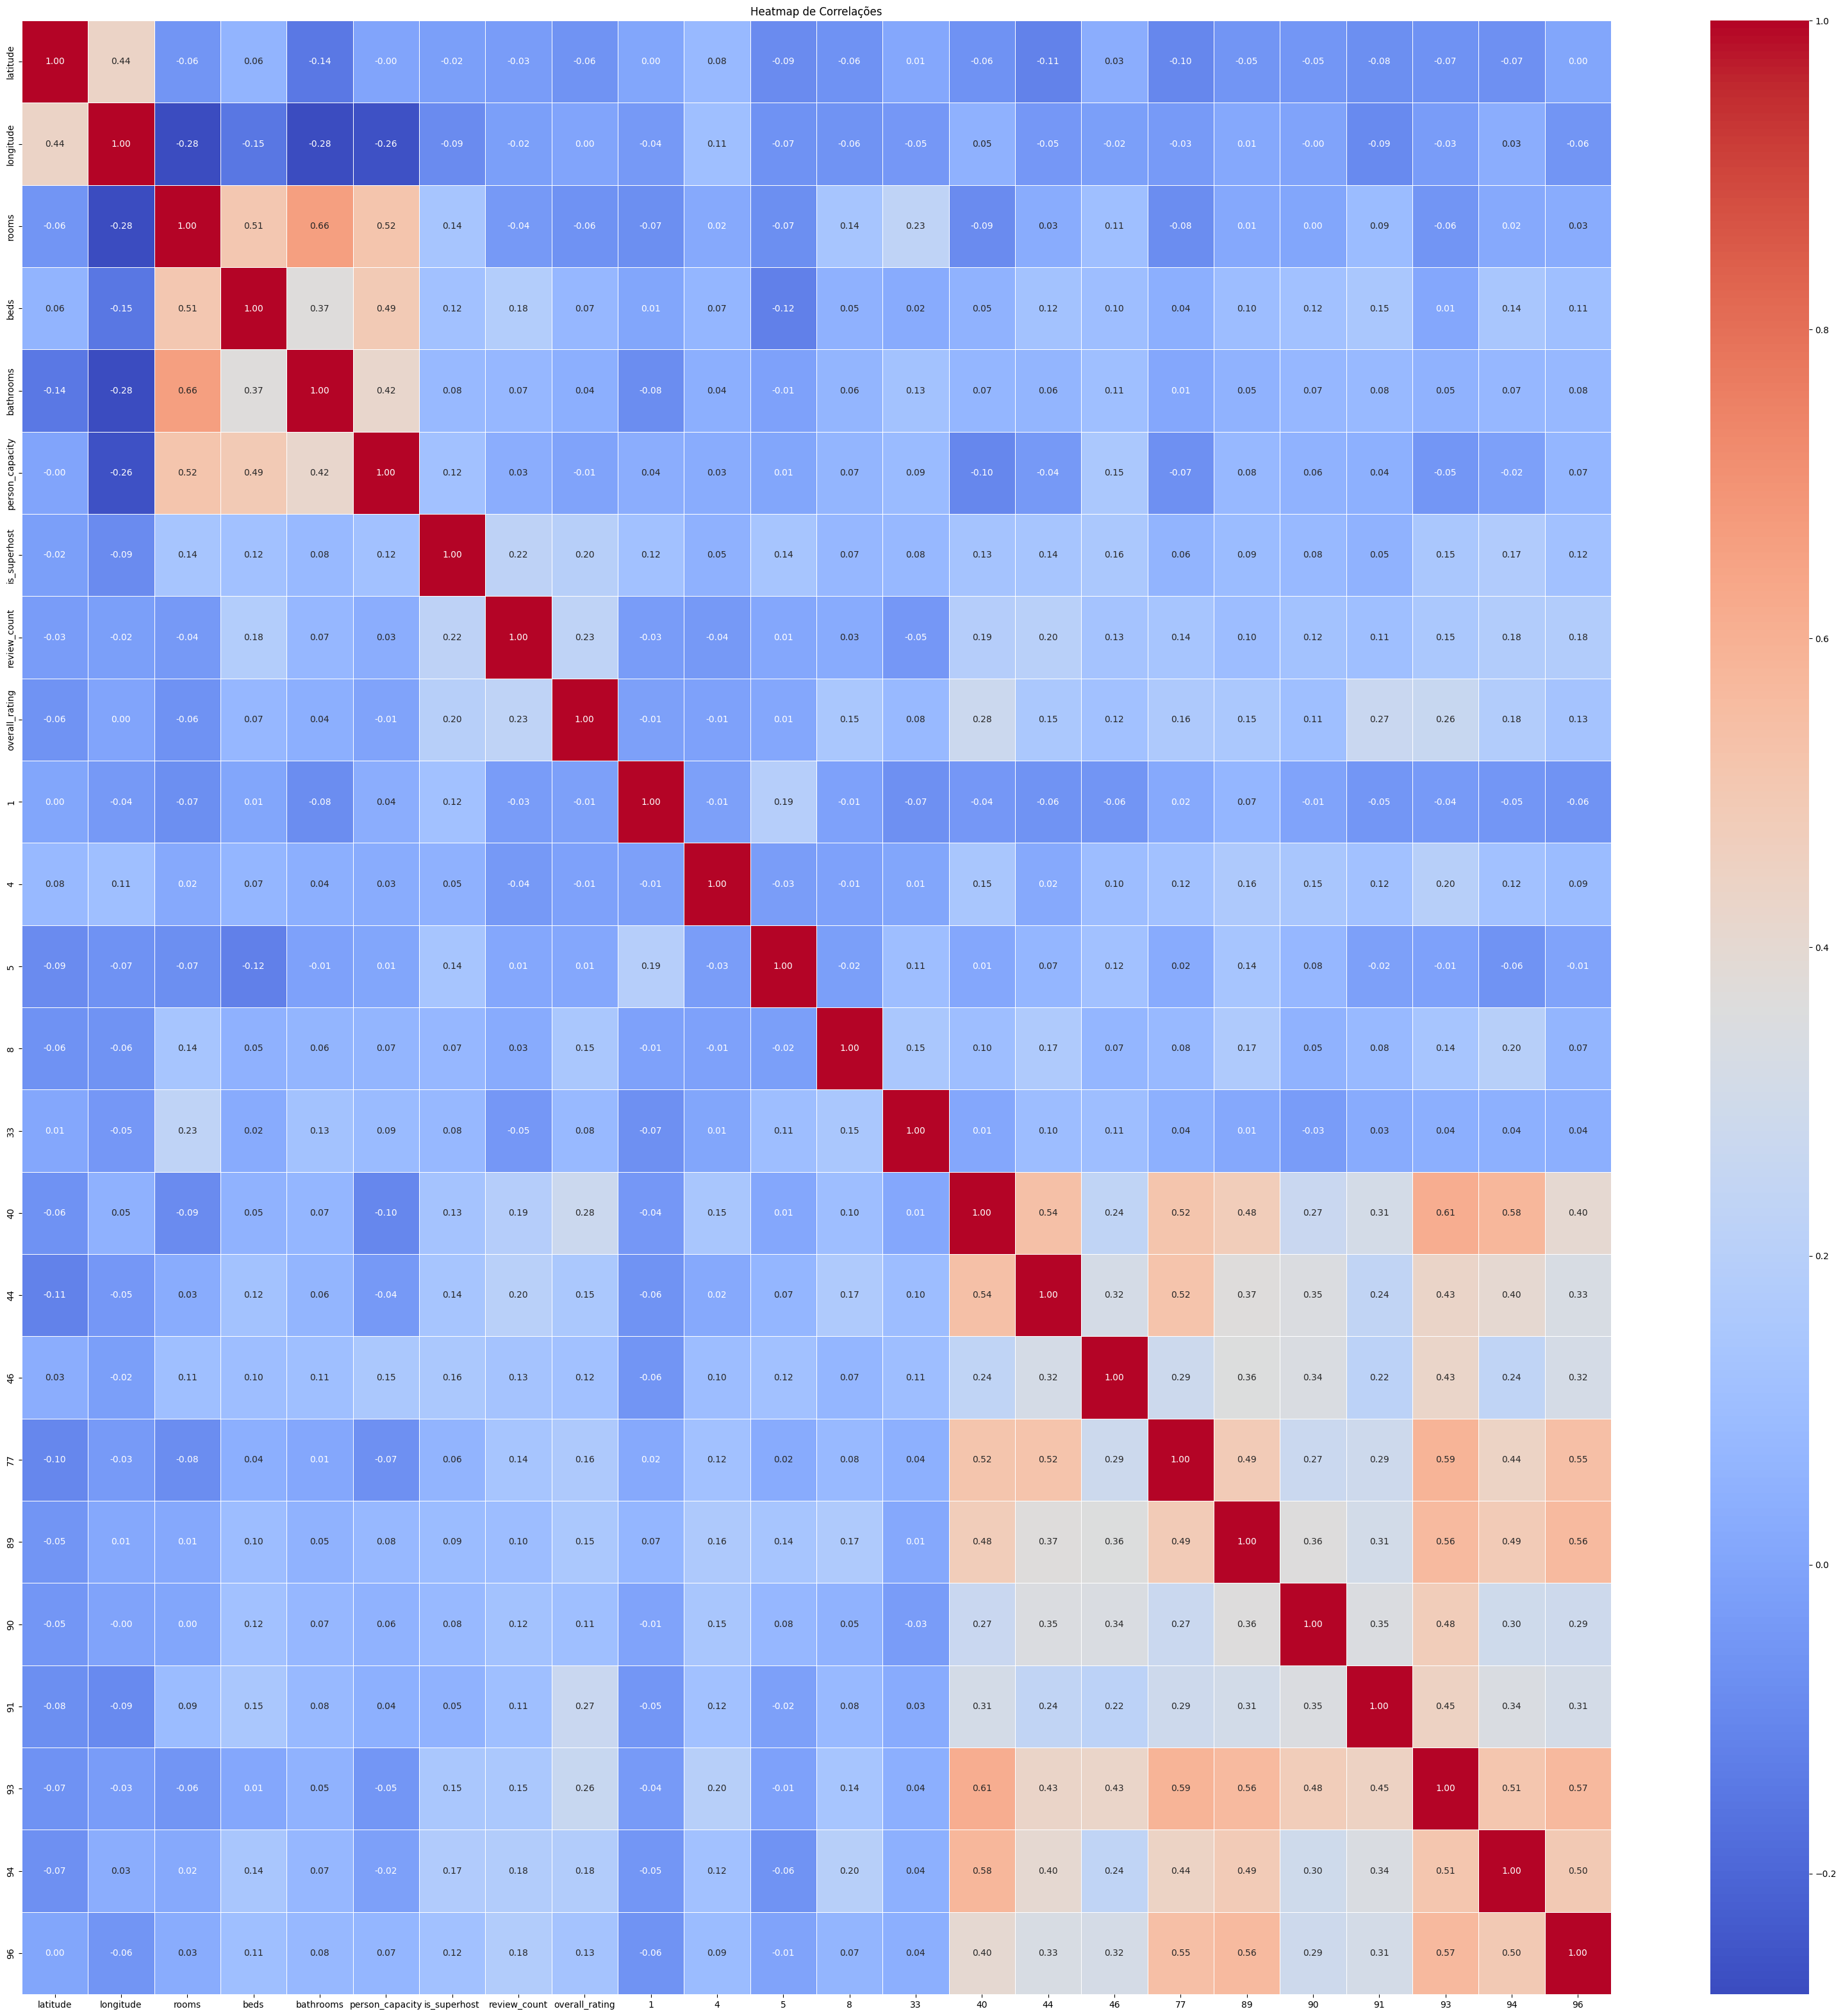

In [18]:
correlation_matrix = corr.corr()
plt.figure(figsize=(40, 40))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Heatmap de Correlações')
plt.show()

In [19]:
X_train, X_test, y_train, y_test = train_test_split(df_copy_X, df_copy_y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

pca = PCA(n_components=0.70, svd_solver='full')
X_train_pca = pd.DataFrame(pca.fit_transform(X_train_scaled), index=X_train.index)
X_test_pca = pd.DataFrame(pca.transform(X_test_scaled), index=X_test.index)

model = LinearRegression()
model.fit(X_train_pca, y_train)
y_pred = model.predict(X_train_pca)
y_pred_val = model.predict(X_test_pca)


print("\nTraining MSE:", round(mean_squared_error(y_train, y_pred),4))
print("Validation MSE:", round(mean_squared_error(y_test, y_pred_val),4))
print("\nTraining r2:", round(r2_score(y_train, y_pred),4))
print("Validation r2:", round(r2_score(y_test, y_pred_val),4))


Training MSE: 8393.1669
Validation MSE: 15818.8901

Training r2: 0.5266
Validation r2: 0.3338


In [20]:
X_test['y_hat'] = y_pred_val
X_test['price'] = y_test
X_test['modulo'] = abs(X_test['price'] - X_test['y_hat'])
X_test['percentual'] = (X_test['modulo']/X_test['price'])*100
X_test['percentual'].mean()

29.91793019688927

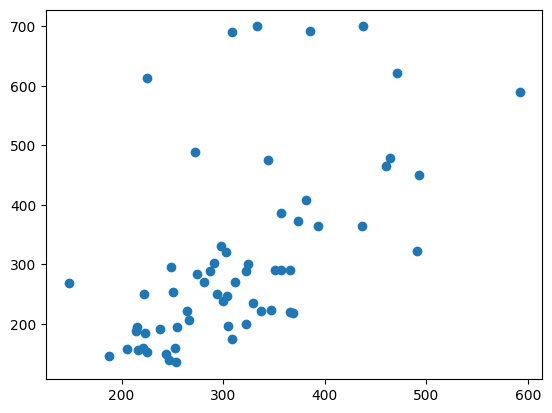

In [21]:
plt.scatter(X_test['y_hat'], X_test['price'])

In [22]:
X_test

,latitude,longitude,rooms,beds,bathrooms,person_capacity,is_superhost,review_count,overall_rating,1,2,3,4,...,671,672,674,684,686,687,688,689,693,y_hat,price,modulo,percentual
188,-23.023210,-43.485450,2.0,3,2,5,1,7,5.00,1,1,0,1,...,1,0,0,0,0,0,0,0,0,374.024010,373.0,1.024010,0.274534
161,-23.009170,-43.347960,1.0,3,1,4,0,12,4.58,1,0,0,1,...,0,0,1,0,0,0,0,0,0,491.053296,322.0,169.053296,52.501024
115,-22.988150,-43.190350,1.0,1,1,4,0,90,4.73,1,0,0,1,...,1,0,0,0,0,0,0,0,0,287.568944,289.0,1.431056,0.495175
257,-22.954390,-43.174560,2.0,2,2,6,1,32,4.97,1,0,0,1,...,1,1,0,0,0,0,0,0,0,298.254854,331.0,32.745146,9.892793
64,-22.966130,-43.181240,2.0,2,2,4,1,18,4.94,1,1,0,1,...,1,1,0,0,0,0,0,0,0,368.871126,219.0,149.871126,68.434304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,-22.890470,-43.097010,2.0,4,2,4,1,31,4.87,1,1,0,1,...,1,0,1,0,0,0,0,0,0,220.989776,160.0,60.989776,38.118610
108,-22.968070,-43.187640,1.0,2,1,4,0,57,4.70,1,0,0,1,...,1,0,1,0,0,0,0,0,0,214.843477,194.0,20.843477,10.744061
317,-22.987180,-43.189790,2.0,3,2,4,0,16,4.94,1,0,0,1,...,1,1,1,0,0,0,0,0,0,385.912020,693.0,307.087980,44.312840
202,-22.964200,-43.404140,3.0,4,2,6,1,40,4.83,1,0,0,1,...,1,0,0,0,0,0,0,0,0,300.204588,239.0,61.204588,25.608614
